In [3]:
import pandas as pd
import numpy as np
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.svm import LinearSVC

from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
review_ml = pd.read_csv('predicted_review.csv')   # labelled fake or not
review = pd.read_csv('review_subset.csv')       # without label

# Given any business name, output review rating over time (groupby month)  

In [5]:
def average_review_by_month(business_id):
    train  = review[review['business_id']==business_id]
    data = {'date': train['date'],'stars':train['stars']}
    review_time = pd.DataFrame(data)
    review_time = review_time.set_index('date')
    
    # calcuate average review by month by creating one dict {'date', stars} and one dict_count{'date',count}
    dic = {}
    dic_count = {}
    for d,s in review_time.iterrows():
        datetemp = pd.to_datetime(d)
        timestamp = datetemp.year*1000 + datetemp.month

    
        if timestamp in dic:
            dic[timestamp] += s
            dic_count[timestamp] += 1
        
        else:
            dic[timestamp] = s
            dic_count[timestamp] = 1

    for i in dic:
        dic[i] = dic[i] / dic_count[i]
        
    rate = []
    for i in list(dic.values()):
        rate.append(float(i))
    date = []
    for i in dic.keys():
        date.append(str(i))
        date = sorted(date)
        
    plt.figure(figsize=(50,10))
    my_xticks = date
    plt.xticks(range(0,len(date)),date,rotation = 70,fontsize = 30)
    plt.plot(range(0,len(date)),rate,linewidth=3.0,color = 'blue')
    plt.title(' Average Review Rating By Month', fontsize = 60)
    plt.show()

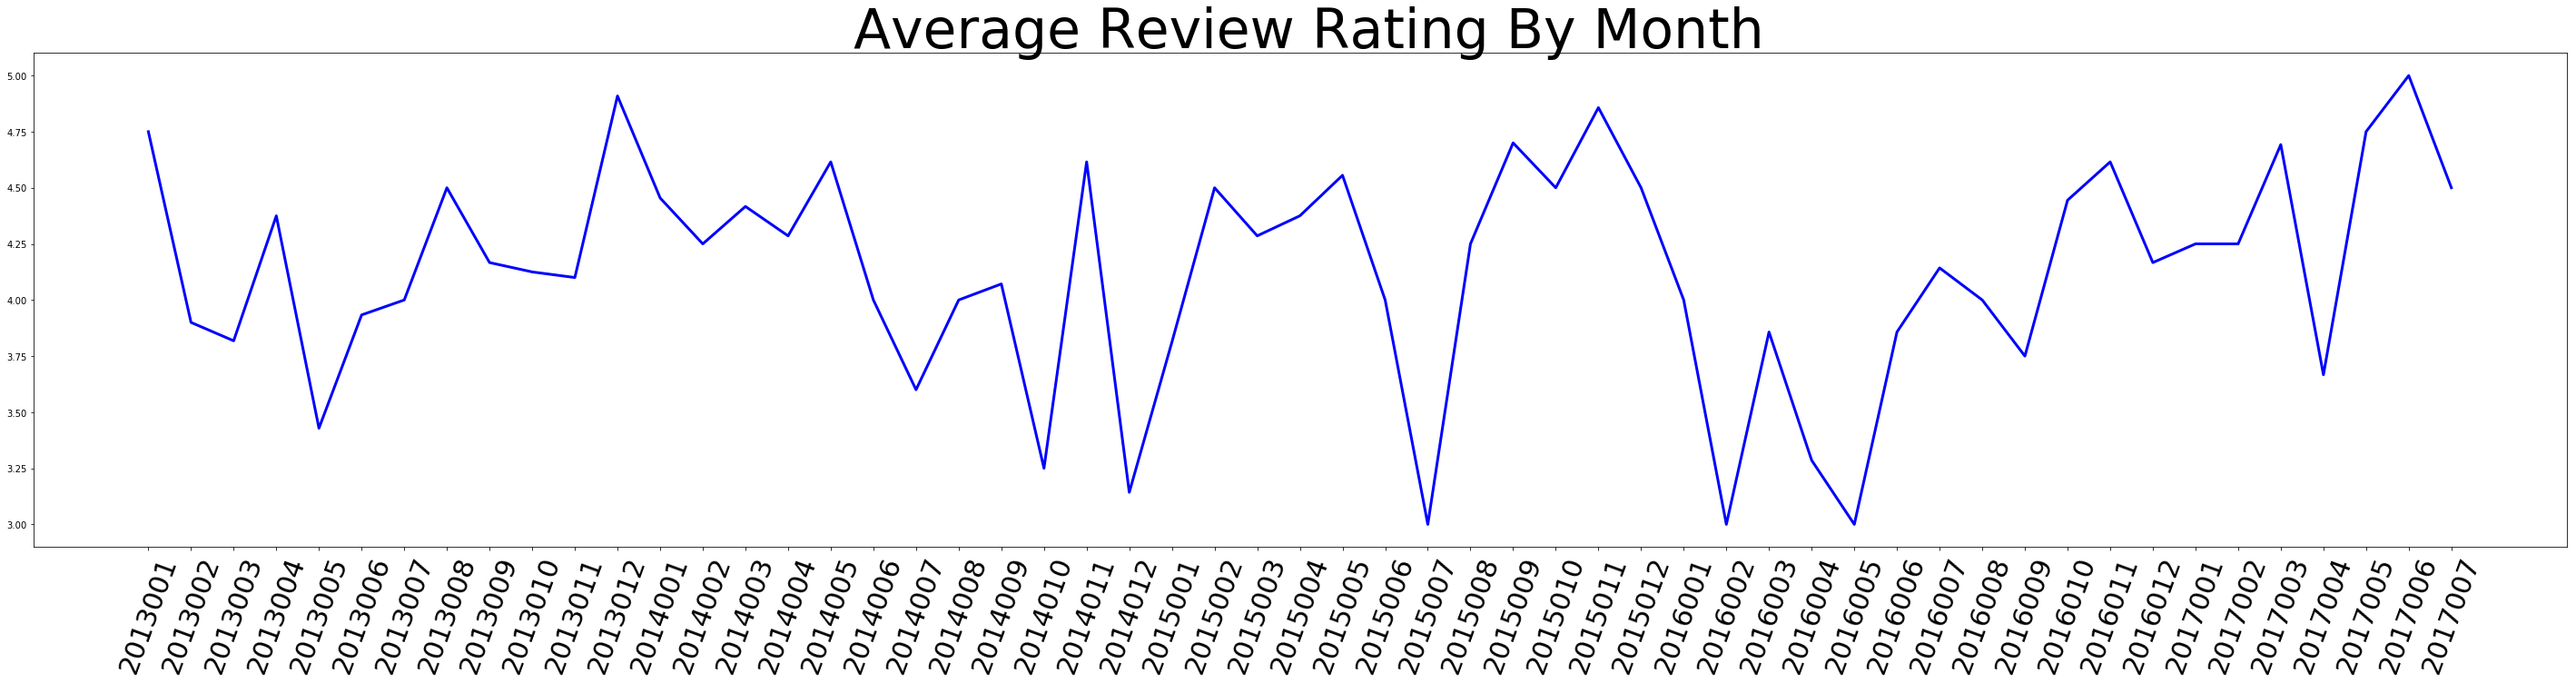

In [6]:
average_review_by_month('zwNC-Ow4eIMan2__bS9-rg')

# Top Words wordcloud

In [7]:
stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()

In [8]:
def text_process(data):
    '''
    Takes in a df in format of [text,stars] performs the following:
    1. Lower capital letters
    2. Remove all punctuation
    3. Remove all stopwords
    4. Reduce words to their word stem
    5. Return a list of words
    
    '''
    for i in range(len(data)):
        line = data[i]
        line = line.lower() # lower case
        translation = str.maketrans("","", string.punctuation);
        line = line.translate(translation)
        split = word_tokenize(line)
         # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        filtered = []
        for token in split:
            if re.search('[a-zA-Z]', token):    
                filtered.append(token)
        word = [i for i in filtered if i not in stopwords.words('english')]
        
        d = [stemmer.stem(word) for word in word] 
        d = [wordnet_lemmatizer.lemmatize(word) for word in d]
        data[i] = d
    return data

In [9]:
def top_words(business_id):
    train  = review_ml[review_ml['business_id'] == business_id][review_ml['True(1)/Deceptive(0)'] == 'True']
    text =  list(train['Review'])  # text    
    text = text_process(text)
    text = sum(text,[])
    
    counts = Counter(text)
    wordcloud = WordCloud(    
                          background_color='white',
                          max_words=100,
                          max_font_size=50,
                          min_font_size=10,
                          random_state=40,
                        
                         ).fit_words(counts)
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')  # remove axis
    plt.show()

/Users/zhiweizhang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


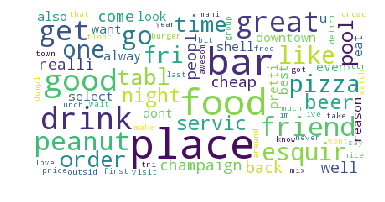

In [10]:
top_words('D6SCh4BwNb52wZIqXdS4JQ')

# Importance features extraction -- one gram and bigram
Given any business name, output bar chart with the most important 10 features contributing to negative and positive review

In [11]:
def change_label(x):
    for i in range(len(x)):
        if x[i] >= 3.0:    # good review: stars >=3.0
            x[i] = 1
        else:              # bad review: stars 3.0
            x[i] = 0
    return x

In [15]:
def onegram(business_id):
    
    train  = review_ml[review_ml['business_id'] == business_id][review_ml['True(1)/Deceptive(0)'] == 'True']
    train_data =  list(train['Review'])    # text
    label = list(train['Stars'])           # ratings
    train_label = change_label(label)
    
    text = text_process(train_data)
    text = sum(text,[])
    text = set(text)
    text = list(text)
    transformer = TfidfVectorizer() 
    cvectorizer = transformer.fit(text)
    transformed = cvectorizer.transform(train['Review'])  
#     print(cvectorizer.get_feature_names())

    # SVM
    clf = LinearSVC()
    clf.fit(transformed,train_label)
    
    coefficients = clf.coef_.ravel()
    pos_coefficients = np.argsort(coefficients )[-10:]
    neg_coefficients = np.argsort(coefficients )[:10]
    combine = np.hstack([neg_coefficients, pos_coefficients])
    
    plt.figure(figsize=(7, 4))
    colors = ['red' if i < 0 else 'blue' for i in coefficients[combine]]
    plt.bar(np.arange(2 * 10), coefficients[combine], color=colors)
    feature_names = np.array(cvectorizer.get_feature_names())
    
    plt.title('why the restaurant is rated as bad or good ', fontsize = 15)
    plt.xticks(np.arange( 0, 2 * 10), feature_names[combine], rotation=40, ha='right')
    plt.show()

/Users/zhiweizhang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


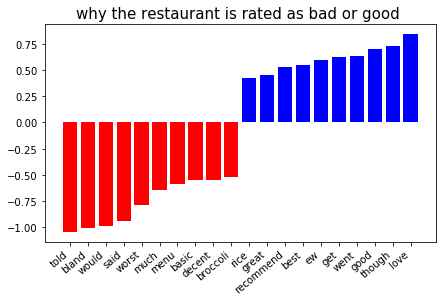

In [16]:
onegram('UmZdQID7QJoyg2R92mK3HA')

In [17]:
def bigram(business_id):
    # only use true review
    
    train  = review_ml[review_ml['business_id'] == business_id][review_ml['True(1)/Deceptive(0)'] == 'True']
    train_data =  list(train['Review'])    # text
    label = list(train['Stars'])           # ratings
    train_label = change_label(label)
    
    # TfidfVectorizer Transform
    transformer = TfidfVectorizer(stop_words ='english', ngram_range=(2,2))  # "ignore terms that appear in less than 1% of the documents".
    cvectorizer = transformer.fit(train['Review'])
    transformed = cvectorizer.transform(train['Review'])

    
    
    # SVM regression
    clf = LinearSVC()
    clf.fit(transformed,train_label)
    
    coefficients = clf.coef_.ravel()
    pos_coefficients = np.argsort(coefficients )[-10:]
    neg_coefficients = np.argsort(coefficients )[:10]
    combine = np.hstack([neg_coefficients, pos_coefficients])
    
    plt.figure(figsize=(7, 4))
    colors = ['red' if i < 0 else 'blue' for i in coefficients[combine]]
    plt.bar(np.arange(2 * 10), coefficients[combine], color=colors)
    feature_names = np.array(cvectorizer.get_feature_names())
    
    plt.title('why the restaurant is rated as bad or good ', fontsize = 15)
    plt.xticks(np.arange( 0, 2 * 10), feature_names[combine], rotation=40, ha='right')
    plt.show()

/Users/zhiweizhang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


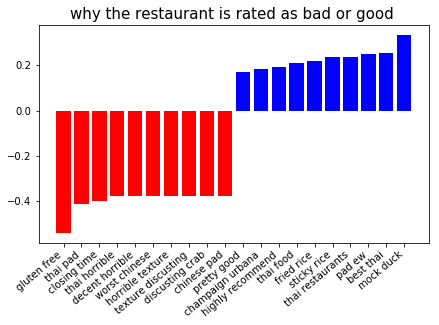

In [18]:
bigram('UmZdQID7QJoyg2R92mK3HA')